# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [3]:
os.environ["SPECTRAL_CONNECTIVITY_ENABLE_GPU"] = "true"
import cupy as cp

In [4]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu


In [5]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import colorsys

In [6]:
from sklearn.metrics import confusion_matrix

In [7]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [8]:
FONTSIZE = 20

In [9]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

# Functions

In [10]:
def generate_pairs(lst):
    """
    Generates all unique pairs from a list.

    Parameters:
    - lst (list): The list to generate pairs from.

    Returns:
    - list: A list of tuples, each containing a unique pair from the input list.
    """
    n = len(lst)
    return [(lst[i], lst[j]) for i in range(n) for j in range(i+1, n)]

## Inputs & Data

Explanation of each input and where it comes from.

In [11]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [12]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000

In [13]:
BAND_TO_FREQ = {"theta": (4,12), "gamma": (30,51)}

In [14]:
LFP_TRACES_DF = pd.read_pickle("./proc/rce_pilot_2_02_standard_spectral.pkl")

In [15]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,...,LH_vHPC_granger_all_frequencies_all_windows,vHPC_LH_granger_all_frequencies_all_windows,MD_mPFC_granger_all_frequencies_all_windows,mPFC_MD_granger_all_frequencies_all_windows,MD_vHPC_granger_all_frequencies_all_windows,vHPC_MD_granger_all_frequencies_all_windows,mPFC_vHPC_granger_all_frequencies_all_windows,vHPC_mPFC_granger_all_frequencies_all_windows,granger_timestamps,granger_calculation_frequencies
0,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,...,"[[1.212, 0.6343, 0.2808, 0.6133, 0.635, 1.502,...","[[0.3904, 0.2316, 0.02307, 0.1547, 0.3137, 0.7...","[[1.767, 1.53, 1.763, 0.898, 1.155, 1.547, 0.1...","[[1.765, 0.7905, 1.229, 0.71, 0.3438, 0.6763, ...","[[1.93, 0.4773, 0.3132, 0.615, 0.8076, 0.6006,...","[[0.1791, 0.1605, 0.01888, 0.0991, 0.268, 0.35...","[[0.3865, 0.2566, 0.1313, 0.1837, 0.2905, nan,...","[[0.000577, 0.1996, 0.2228, 0.5625, 0.6416, 0....","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,...,"[[1.212, 0.6343, 0.2808, 0.6133, 0.635, 1.502,...","[[0.3904, 0.2316, 0.02307, 0.1547, 0.3137, 0.7...","[[1.767, 1.53, 1.763, 0.898, 1.155, 1.547, 0.1...","[[1.765, 0.7905, 1.229, 0.71, 0.3438, 0.6763, ...","[[1.93, 0.4773, 0.3132, 0.615, 0.8076, 0.6006,...","[[0.1791, 0.1605, 0.01888, 0.0991, 0.268, 0.35...","[[0.3865, 0.2566, 0.1313, 0.1837, 0.2905, nan,...","[[0.000577, 0.1996, 0.2228, 0.5625, 0.6416, 0....","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,1.4,...,"[[2.48, 1.336, 0.662, 0.2261, 0.1403, 0.1016, ...","[[1.638, 0.751, 0.1073, 0.3499, 0.261, 0.593, ...","[[0.11383, 0.06714, 0.1582, 0.02718, 0.1484, 0...","[[1.162, 0.1947, 0.391, 0.1361, 0.209, 0.6934,...","[[1.679, 1.423, 0.822, 0.2617, 0.0925, 0.03287...","[[0.985, 0.4849, 0.1306, 0.3406, 0.2705, 0.308...","[[1.434, 2.254, 0.567, 0.3025, 0.1377, 0.6514,...","[[nan, 0.83, 1.557, 0.672, 0.3513, 0.01386, 0....","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,1.4,...,"[[2.48, 1.336, 0.662, 0.2261, 0.1403, 0.1016, ...","[[1.638, 0.751, 0.1073, 0.3499, 0.261, 0.593, ...","[[0.11383, 0.06714, 0.1582, 0.02718, 0.1484, 0...","[[1.162, 0.1947, 0.391, 0.1361, 0.209, 0.6934,...","[[1.679, 1.423, 0.822, 0.2617, 0.0925, 0.03287...","[[0.985, 0.4849, 0.1306, 0.3406, 0.2705, 0.308...","[[1.434, 2.254, 0.567, 0.3025, 0.1377, 0.6514,...","[[nan, 0.83, 1.557, 0.672, 0.3513, 0.0

# Looking at where the power is infinite

In [18]:
LFP_TRACES_DF["mPFC_power_all_frequencies_all_windows"].iloc[0]

array([[1.2552e+04, 2.4160e+04, 2.7040e+04, ..., 5.5199e-03, 5.0812e-03,
        6.3438e-03],
       [1.3410e+03, 7.3200e+02, 1.7130e+03, ..., 3.8177e-02, 4.0863e-02,
        4.4434e-02],
       [1.7070e+03, 3.0880e+03, 3.2860e+03, ..., 6.2805e-02, 6.0333e-02,
        6.0852e-02],
       ...,
       [8.9500e+02, 1.3984e+04, 2.5216e+04, ..., 1.7297e-01, 1.7761e-01,
        1.8433e-01],
       [5.8720e+03, 3.9820e+03, 4.5040e+03, ..., 1.1490e-02, 1.1375e-02,
        1.1673e-02],
       [1.5090e+03, 5.8920e+03, 5.2360e+03, ..., 3.6469e-02, 3.2013e-02,
        3.5522e-02]], dtype=float16)

In [30]:
example_window = LFP_TRACES_DF["mPFC_power_all_frequencies_all_windows"].iloc[0].copy()

In [31]:
from numpy import inf

In [34]:
example_window.shape

(6828, 500)

- Looking at when Theta is infinite

In [45]:
all_infinite_indexes = []
for index, row in enumerate(example_window.T):
    if index <= 7 or index >= 12:
        continue
    
    if inf in row:
        print(index)
        current_indexes = np.where(row == inf)
        all_infinite_indexes.append(current_indexes)



8
9
10
11


In [55]:
unique_infinite_indexes = np.sort(np.unique(np.concatenate(all_infinite_indexes, axis=1).flatten()))

In [56]:
unique_infinite_indexes

array([  38,   39,   40,   41,   42,   43,   44,   45,   46,   47,   56,
         57,   61,   62,   63,   64,   65,   66,   67,   68,   69,   70,
         71,   72,   75,   76,   77,   78,   79,   80,   81,   82,   83,
         84,   85,   86,   88,   89,   90,   91,   92,   93,   94,  124,
        125,  126,  127,  128,  129,  135,  136,  137,  138,  160,  309,
        310,  311,  312,  313,  345,  346,  347,  405,  406,  407,  408,
        409,  410,  411,  412,  413,  414,  415,  416,  417,  418,  419,
        420,  421,  423,  424,  425,  893,  894, 1157, 1158, 1159, 1671,
       1672, 1673, 1674, 1675, 1676, 1677, 1715, 1716, 1717, 1718, 1719,
       1720, 1721, 1723, 1724, 1725, 1726, 1727, 1728, 1752, 1753, 1754,
       1755, 1756, 1757, 1758, 1759, 1760, 1761, 1769, 1770, 1774, 1775,
       1776, 1777, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267,
       2269, 2270, 2271, 2534, 2537, 2538, 2539, 2585, 2586, 2587, 2588,
       2591, 2592, 2593, 3503, 3504, 3808, 3809, 38

In [460]:
LFP_SAMPLING_RATE = 1000

In [635]:
START_TIME = 0
END_TIME = 3000

In [636]:
START_TIME = 300
END_TIME = 600

In [677]:
START_TIME = 1250
END_TIME = 1300

In [659]:
START_TIME = 2300
END_TIME = 2350

In [678]:
LFP_TRACES_DF["lfp_timestamps"].iloc[0]

array([       0,       20,       40, ..., 68293300, 68293320, 68293340],
      dtype=int32)

In [679]:
lfp_timestamps = LFP_TRACES_DF["lfp_timestamps"].iloc[0][START_TIME * LFP_SAMPLING_RATE: END_TIME * LFP_SAMPLING_RATE]

In [680]:
lfp_timestamps

array([25000000, 25000020, 25000040, ..., 25999940, 25999960, 25999980],
      dtype=int32)

In [681]:
power_timestamps = LFP_TRACES_DF["power_timestamps"].iloc[0].copy()

In [682]:
power_timestamps = power_timestamps[unique_infinite_indexes]

In [683]:
power_timestamps = power_timestamps[(power_timestamps >= lfp_timestamps[0]) & (power_timestamps <= lfp_timestamps[-1])]

In [684]:
power_timestamps

array([25350000, 25380000, 25390000, 25400000, 25860000, 25870000,
       25880000, 25890000, 25920000, 25930000, 25940000], dtype=int32)

In [685]:
LFP_TRACES_DF["recording"].iloc[0]

'20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged'

In [686]:
box_1_port_entries = LFP_TRACES_DF["box_1_port_entry_timestamps"].iloc[0]

In [687]:
box_1_port_entries = box_1_port_entries[(box_1_port_entries[:,0] >= lfp_timestamps[0]) & (box_1_port_entries[:,0] <= lfp_timestamps[-1])]

In [688]:
box_1_port_entries

array([[25086207, 25111607],
       [25129607, 25147207],
       [25158407, 25179006],
       [25203007, 25222206],
       [25266809, 25300607],
       [25331027, 25341409],
       [25359407, 25367806],
       [25385006, 25391809],
       [25407609, 25410406],
       [25415209, 25417007],
       [25437209, 25438207],
       [25533406, 25535409],
       [25540606, 25585606],
       [25589206, 25590406],
       [25590806, 25591809],
       [25657206, 25658206],
       [25693006, 25694009],
       [25712407, 25715006],
       [25733406, 25735006],
       [25736406, 25738006],
       [25744009, 25745409],
       [25757806, 25760006],
       [25778006, 25780809],
       [25790006, 25790806],
       [25863006, 25864806],
       [25866406, 25869406],
       [25935806, 25937206],
       [25937806, 25945008],
       [25984406, 25987209]], dtype=int32)

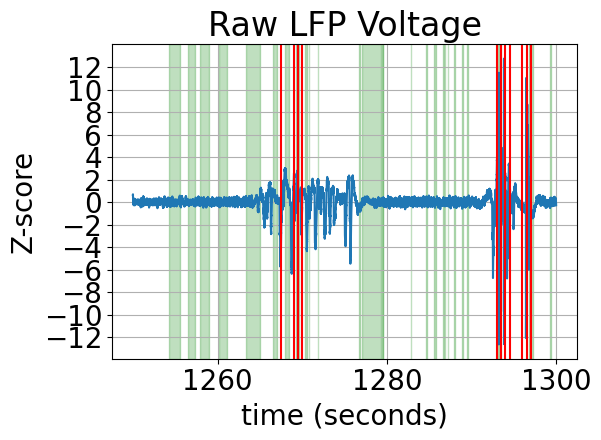

In [689]:
current_traces = stats.zscore(LFP_TRACES_DF["mPFC_lfp_trace"].iloc[0].astype(int))[START_TIME * LFP_SAMPLING_RATE: END_TIME * LFP_SAMPLING_RATE].copy()
plt.plot(lfp_timestamps / 20000, current_traces)

for timestamp in power_timestamps:
    plt.axvline(timestamp/20000, ymin=current_traces.min(), ymax=current_traces.max(), color="red")

for timestamp in box_1_port_entries:
    plt.axvspan(timestamp[0]/20000, timestamp[1]/20000, alpha=0.25, color='green')


plt.xlabel("time (seconds)")
plt.ylabel("Z-score")
plt.title("Raw LFP Voltage")
plt.tight_layout()
plt.yticks(np.arange(int(min(current_traces)), int(max(current_traces))+1, 2.0))
plt.grid()
plt.savefig("./proc/lfp_power_troubleshoot/{}_{}_zscore_no_lines.png".format(START_TIME, END_TIME))

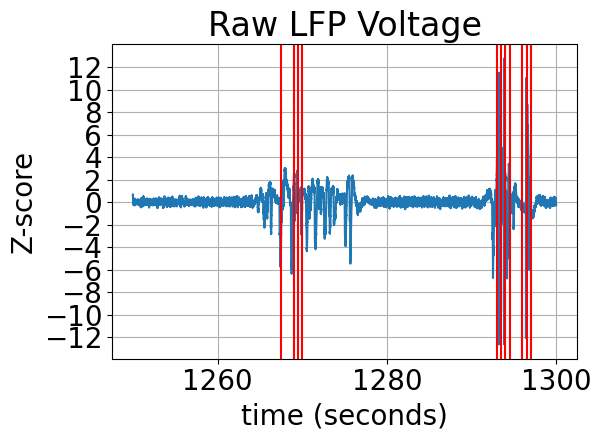

In [690]:
current_traces = stats.zscore(LFP_TRACES_DF["mPFC_lfp_trace"].iloc[0].astype(int))[START_TIME * LFP_SAMPLING_RATE: END_TIME * LFP_SAMPLING_RATE].copy()
plt.plot(lfp_timestamps / 20000, current_traces)
for timestamp in power_timestamps:
    plt.axvline(timestamp/20000, ymin=current_traces.min(), ymax=current_traces.max(), color="red")
plt.xlabel("time (seconds)")
plt.ylabel("Z-score")
plt.title("Raw LFP Voltage")
plt.tight_layout()
plt.yticks(np.arange(int(min(current_traces)), int(max(current_traces))+1, 2.0))
plt.grid()
plt.savefig("./proc/lfp_power_troubleshoot/{}_{}_zscore_yes_lines.png".format(START_TIME, END_TIME))

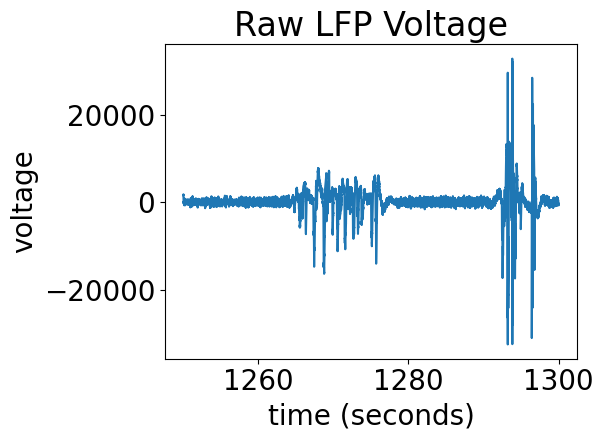

In [691]:
current_traces = LFP_TRACES_DF["mPFC_lfp_trace"].iloc[0][START_TIME * LFP_SAMPLING_RATE: END_TIME * LFP_SAMPLING_RATE].copy()
plt.plot(lfp_timestamps / 20000, current_traces)
# for timestamp in power_timestamps:
#     plt.axvline(timestamp/20000, ymin=current_traces.min(), ymax=current_traces.max(), color="red")
plt.xlabel("time (seconds)")
plt.ylabel("voltage")
plt.title("Raw LFP Voltage")
plt.tight_layout()
plt.savefig("./proc/lfp_power_troubleshoot/{}_{}_voltage_no_lines.png".format(START_TIME, END_TIME))

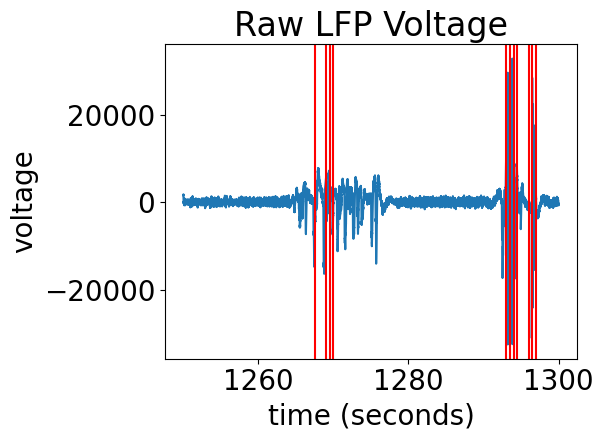

In [692]:
current_traces = LFP_TRACES_DF["mPFC_lfp_trace"].iloc[0][START_TIME * LFP_SAMPLING_RATE: END_TIME * LFP_SAMPLING_RATE].copy()
max_current_traces = current_traces.max()
min_current_traces = current_traces.min()

plt.plot(lfp_timestamps / 20000, current_traces)
for timestamp in power_timestamps:
    plt.axvline(timestamp/20000, ymin=min_current_traces, ymax=max_current_traces, color="red")
plt.xlabel("time (seconds)")
plt.ylabel("voltage")
plt.title("Raw LFP Voltage")
plt.tight_layout()
plt.savefig("./proc/lfp_power_troubleshoot/{}_{}_voltage_yes_lines.png".format(START_TIME, END_TIME))

In [693]:
power_timestamps = LFP_TRACES_DF["power_timestamps"].iloc[0].copy()

power_indexes = np.where((power_timestamps >= lfp_timestamps[0]) & (power_timestamps <= lfp_timestamps[-1]))

power_timestamps = power_timestamps[(power_timestamps >= lfp_timestamps[0]) & (power_timestamps <= lfp_timestamps[-1])]

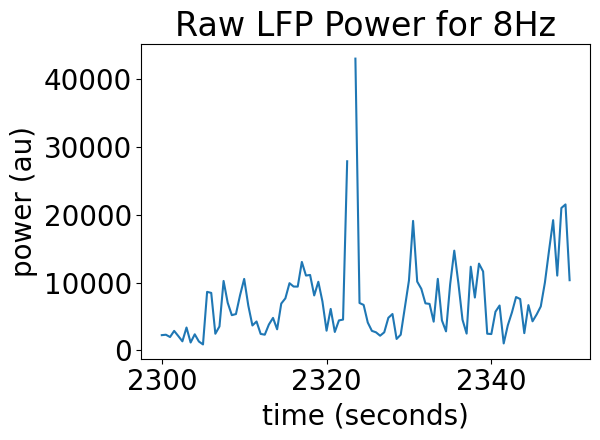

In [676]:
plt.plot(power_timestamps / 20000, LFP_TRACES_DF["mPFC_power_all_frequencies_all_windows"].iloc[0][:,8][power_indexes])
plt.xlabel("time (seconds)")
plt.ylabel("power (au)")
plt.title("Raw LFP Power for 8Hz")
plt.tight_layout()
plt.savefig("./proc/lfp_power_troubleshoot/{}_{}_power_no_lines.png".format(START_TIME, END_TIME))